# Simulate some data to test the method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model, age_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = MIST_Isochrone(bands)
mist.initialize()

Draw randomly from mass, age, metallicity, distance and extinction distributions. Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


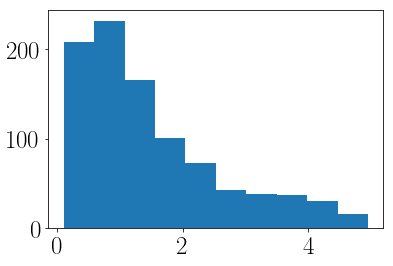

In [2]:
np.random.seed(42)
N = 1000
eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
age = np.random.uniform(8, 10.14, size=N)
age_err = .1
feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
mass = mist.interp_value([eep, age, feh], ["mass"])
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

# N = 1000
# eep, eep_err = np.random.uniform(250, 320, size=N), np.ones(N)*10
# age = np.log10(np.random.uniform(1, 3, size=N)*1e9)
# age_err = age*.2
# feh, feh_err = np.random.randn(N)*.01, np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
# d_kpc = np.random.uniform(.01, 1, size=N)
# dkpc_err = d_kpc*.1
# d_pc = d_kpc*1e3
# dpc_err = d_pc*.1
# av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01
plt.hist(mass);

In [3]:
def model_grid(eep, eep_err, age, age_err, feh, feh_err, d_kpc, dkpc_err, av, av_err):
    mass = mist.interp_value([eep, age, feh], ["mass"])

    # Save as a pandas data frame
    df = pd.DataFrame(dict({"eep": eep, "eep_err": eep_err,
                            "age": age, "age_err": age_err,
                            "feh": feh, "feh_err": feh_err,
                            "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                            "Av": av, "Av_err": av_err}))
    
    logg, teff, feh_interp, B, V, J, H, K, bp, rp, logL = [np.zeros(len(eep)) for i in range(11)]
    for i in trange(len(eep)):
        teff[i], logg[i], feh_interp[i], bands = mist.interp_mag(
            [eep[i], age[i], feh[i], d_kpc[i]*1e-3, av[i]], 
            ["B", "V", "J", "H", "K", "BP", "RP"])
        B[i], V[i], J[i], H[i], K[i], bp[i], rp[i] = bands
        logL[i] = mist.interp_value([eep[i], age[i], feh[i]], ["logL"])[0]
    
    df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"], df["bp"], df["rp"] = B - V, \
        B, V, J, H, K, bp, rp
    df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
    df["mass"] = mist.mass(df.eep, df.age, df.feh)
    
    return df

df = model_grid(eep, eep_err, age, age_err, feh, feh_err, d_kpc, dkpc_err, av, av_err)

100%|██████████| 1000/1000 [00:00<00:00, 14984.58it/s]


Plot the simulated data on an HR diagram.

Text(0, 0.5, '$\\log(g)$')

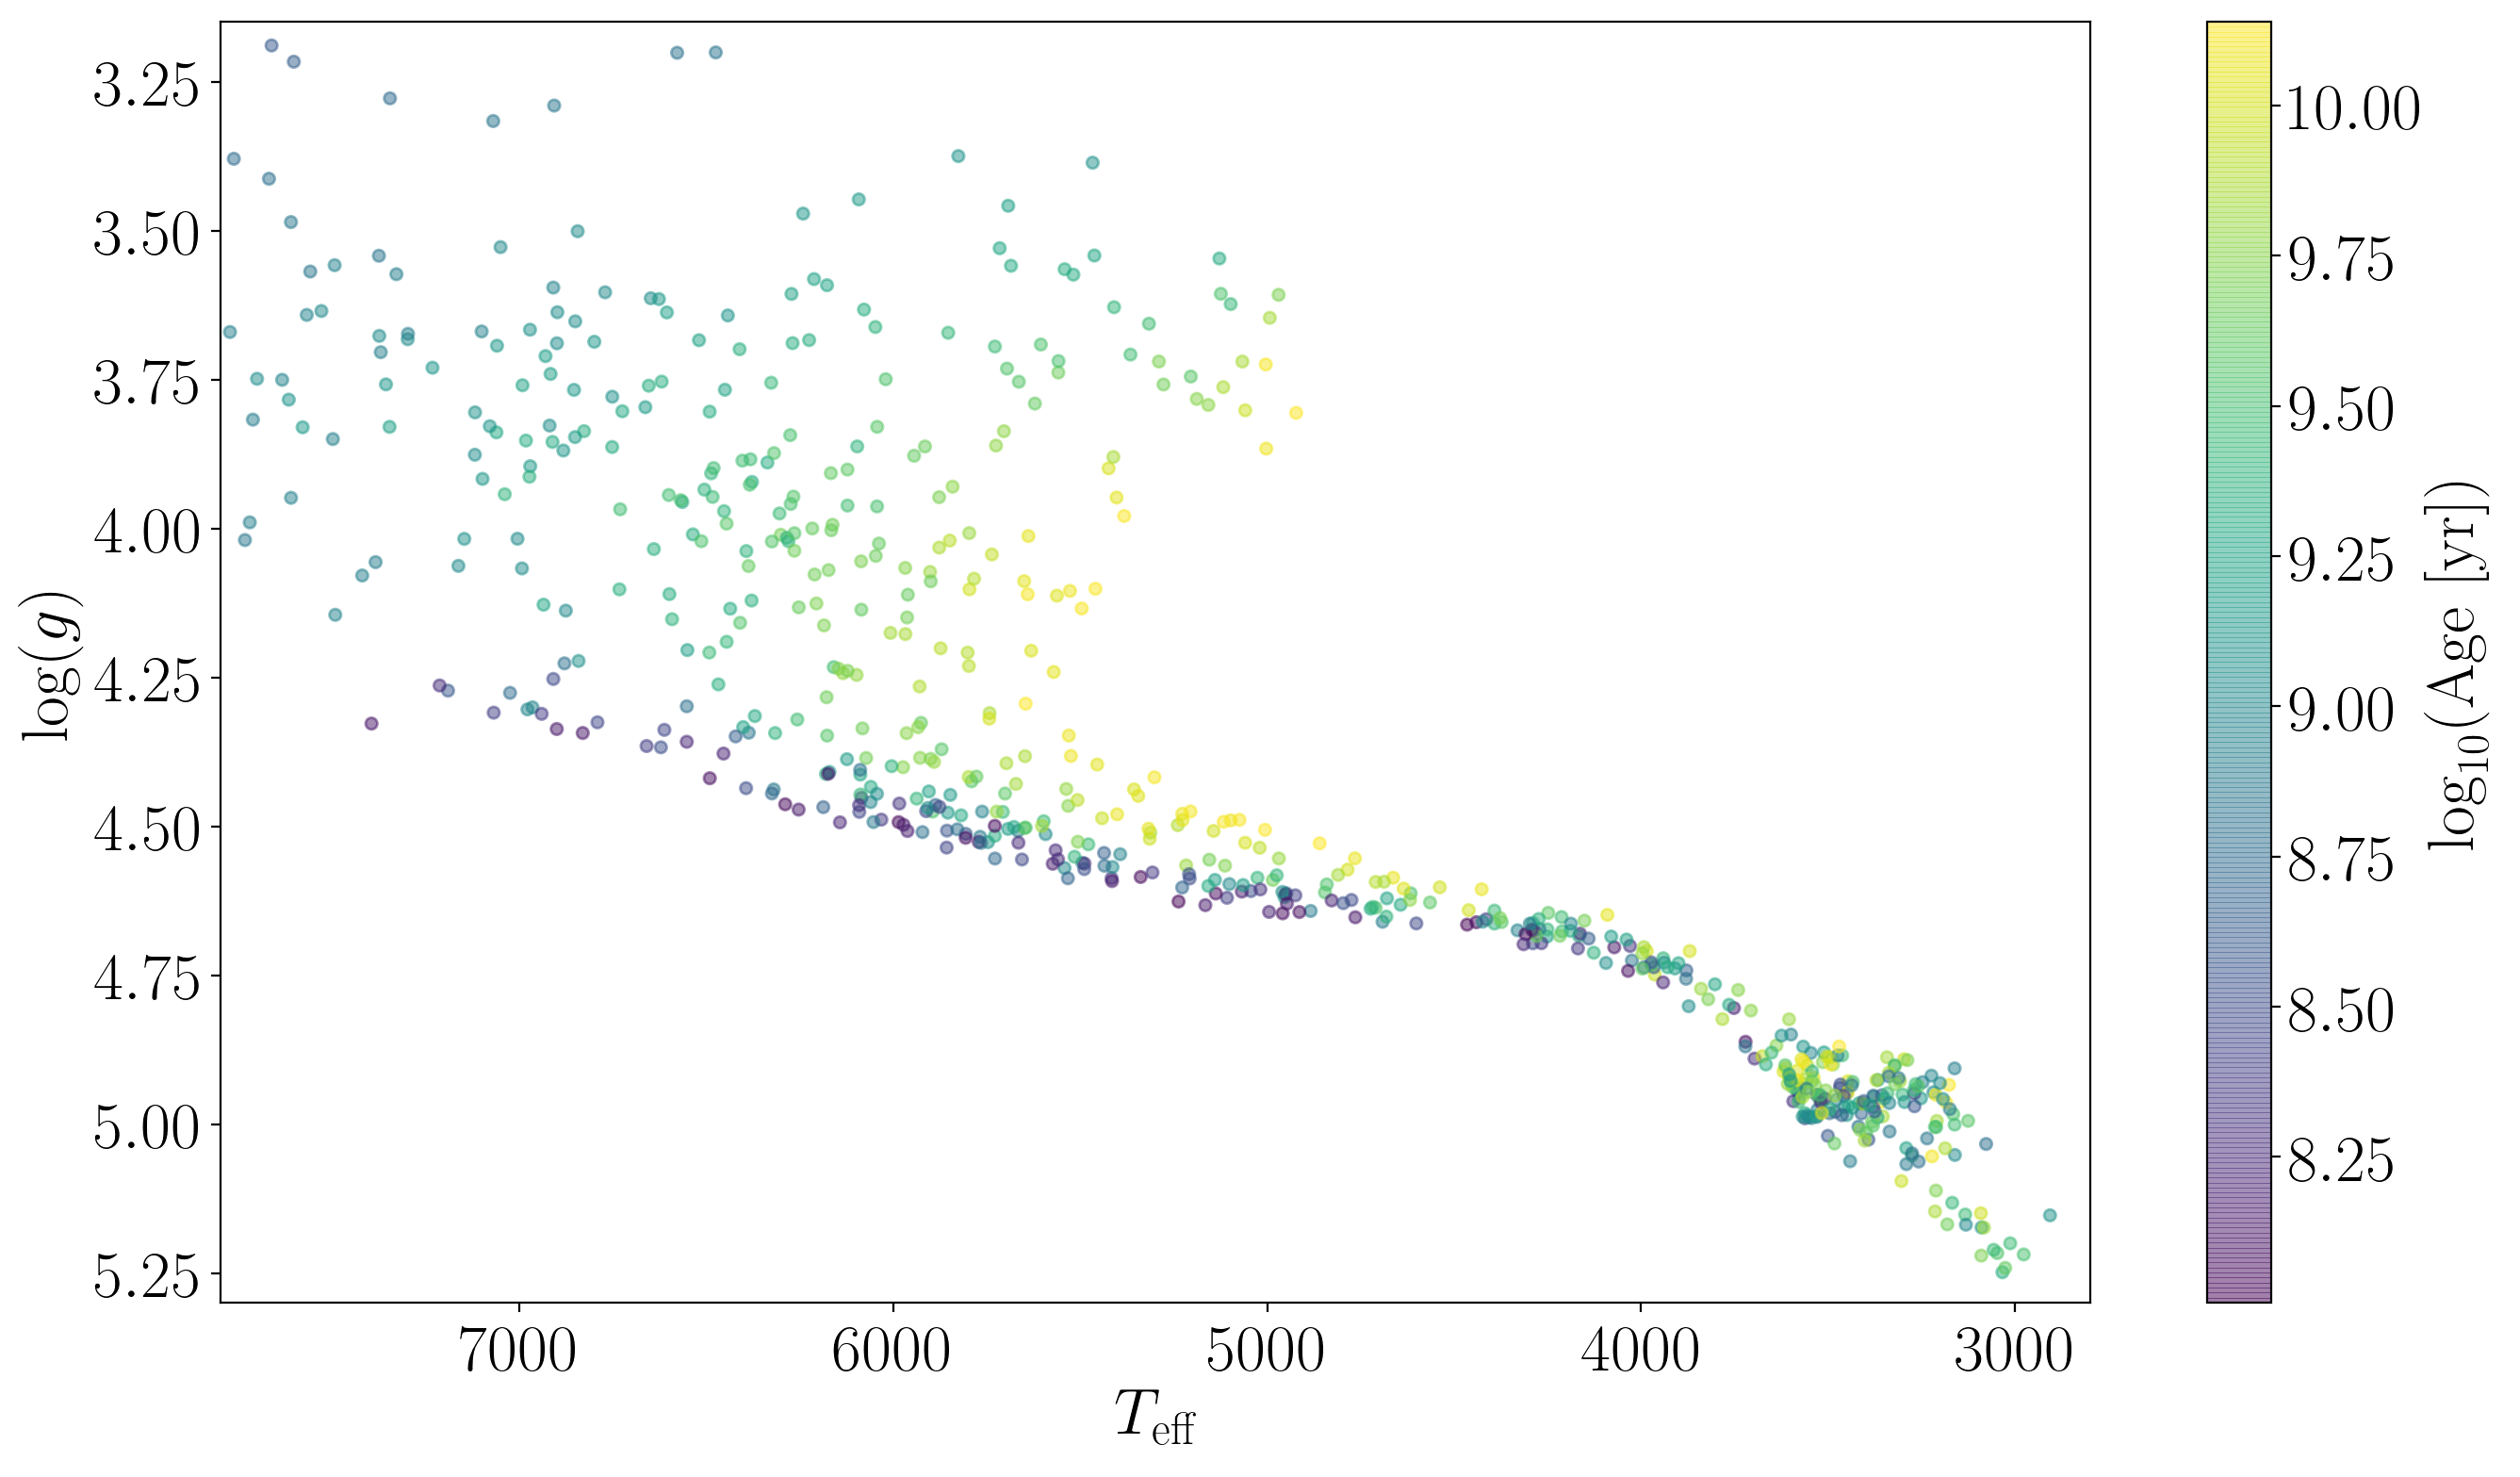

In [4]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20, alpha=.5)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and BP-RP colours.

In [5]:
# Calculate periods.
log_prot, prot_err, log_prot_angus = [np.empty(N) for i in range(3)]
period_uncertainty = .05
for i in trange(N):
    log_prot[i] = gyro_model_rossby(df.age.values[i], 
                                    np.log10(df.bp.values[i] - df.rp.values[i]),
                                    df.mass.values[i], Ro_cutoff=1.8)
    prot_err[i] = (10**log_prot[i])*period_uncertainty
#     log_prot_angus[i] = gyro_model_rossby(df.age.values[i], 
#                                     np.log10(df.bp.values[i] - df.rp.values[i]),
#                                     df.mass.values[i], Ro_cutoff=1.8, model="angus15")

# Add variance to these.
sig = sigma(np.log10(df.bp.values - df.rp.values), df.eep.values)
scatter = np.random.randn(len(log_prot))*sig
log_prot_scatter = log_prot + scatter
# log_prot_angus_scatter = log_prot_angus + scatter

df["prot"] = 10**log_prot_scatter
df["prot_clean"] = 10**log_prot
df["prot_err"] = prot_err
df["Ro"] = calc_rossby_number(df.prot, df.mass)
# df["prot_angus"] = 10**log_prot_angus_scatter

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values) * np.isfinite(df.prot.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")

  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
100%|██████████| 1000/1000 [00:00<00:00, 19576.77it/s]

1000 stars originally,  806 after cuts



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(0, 3.5)

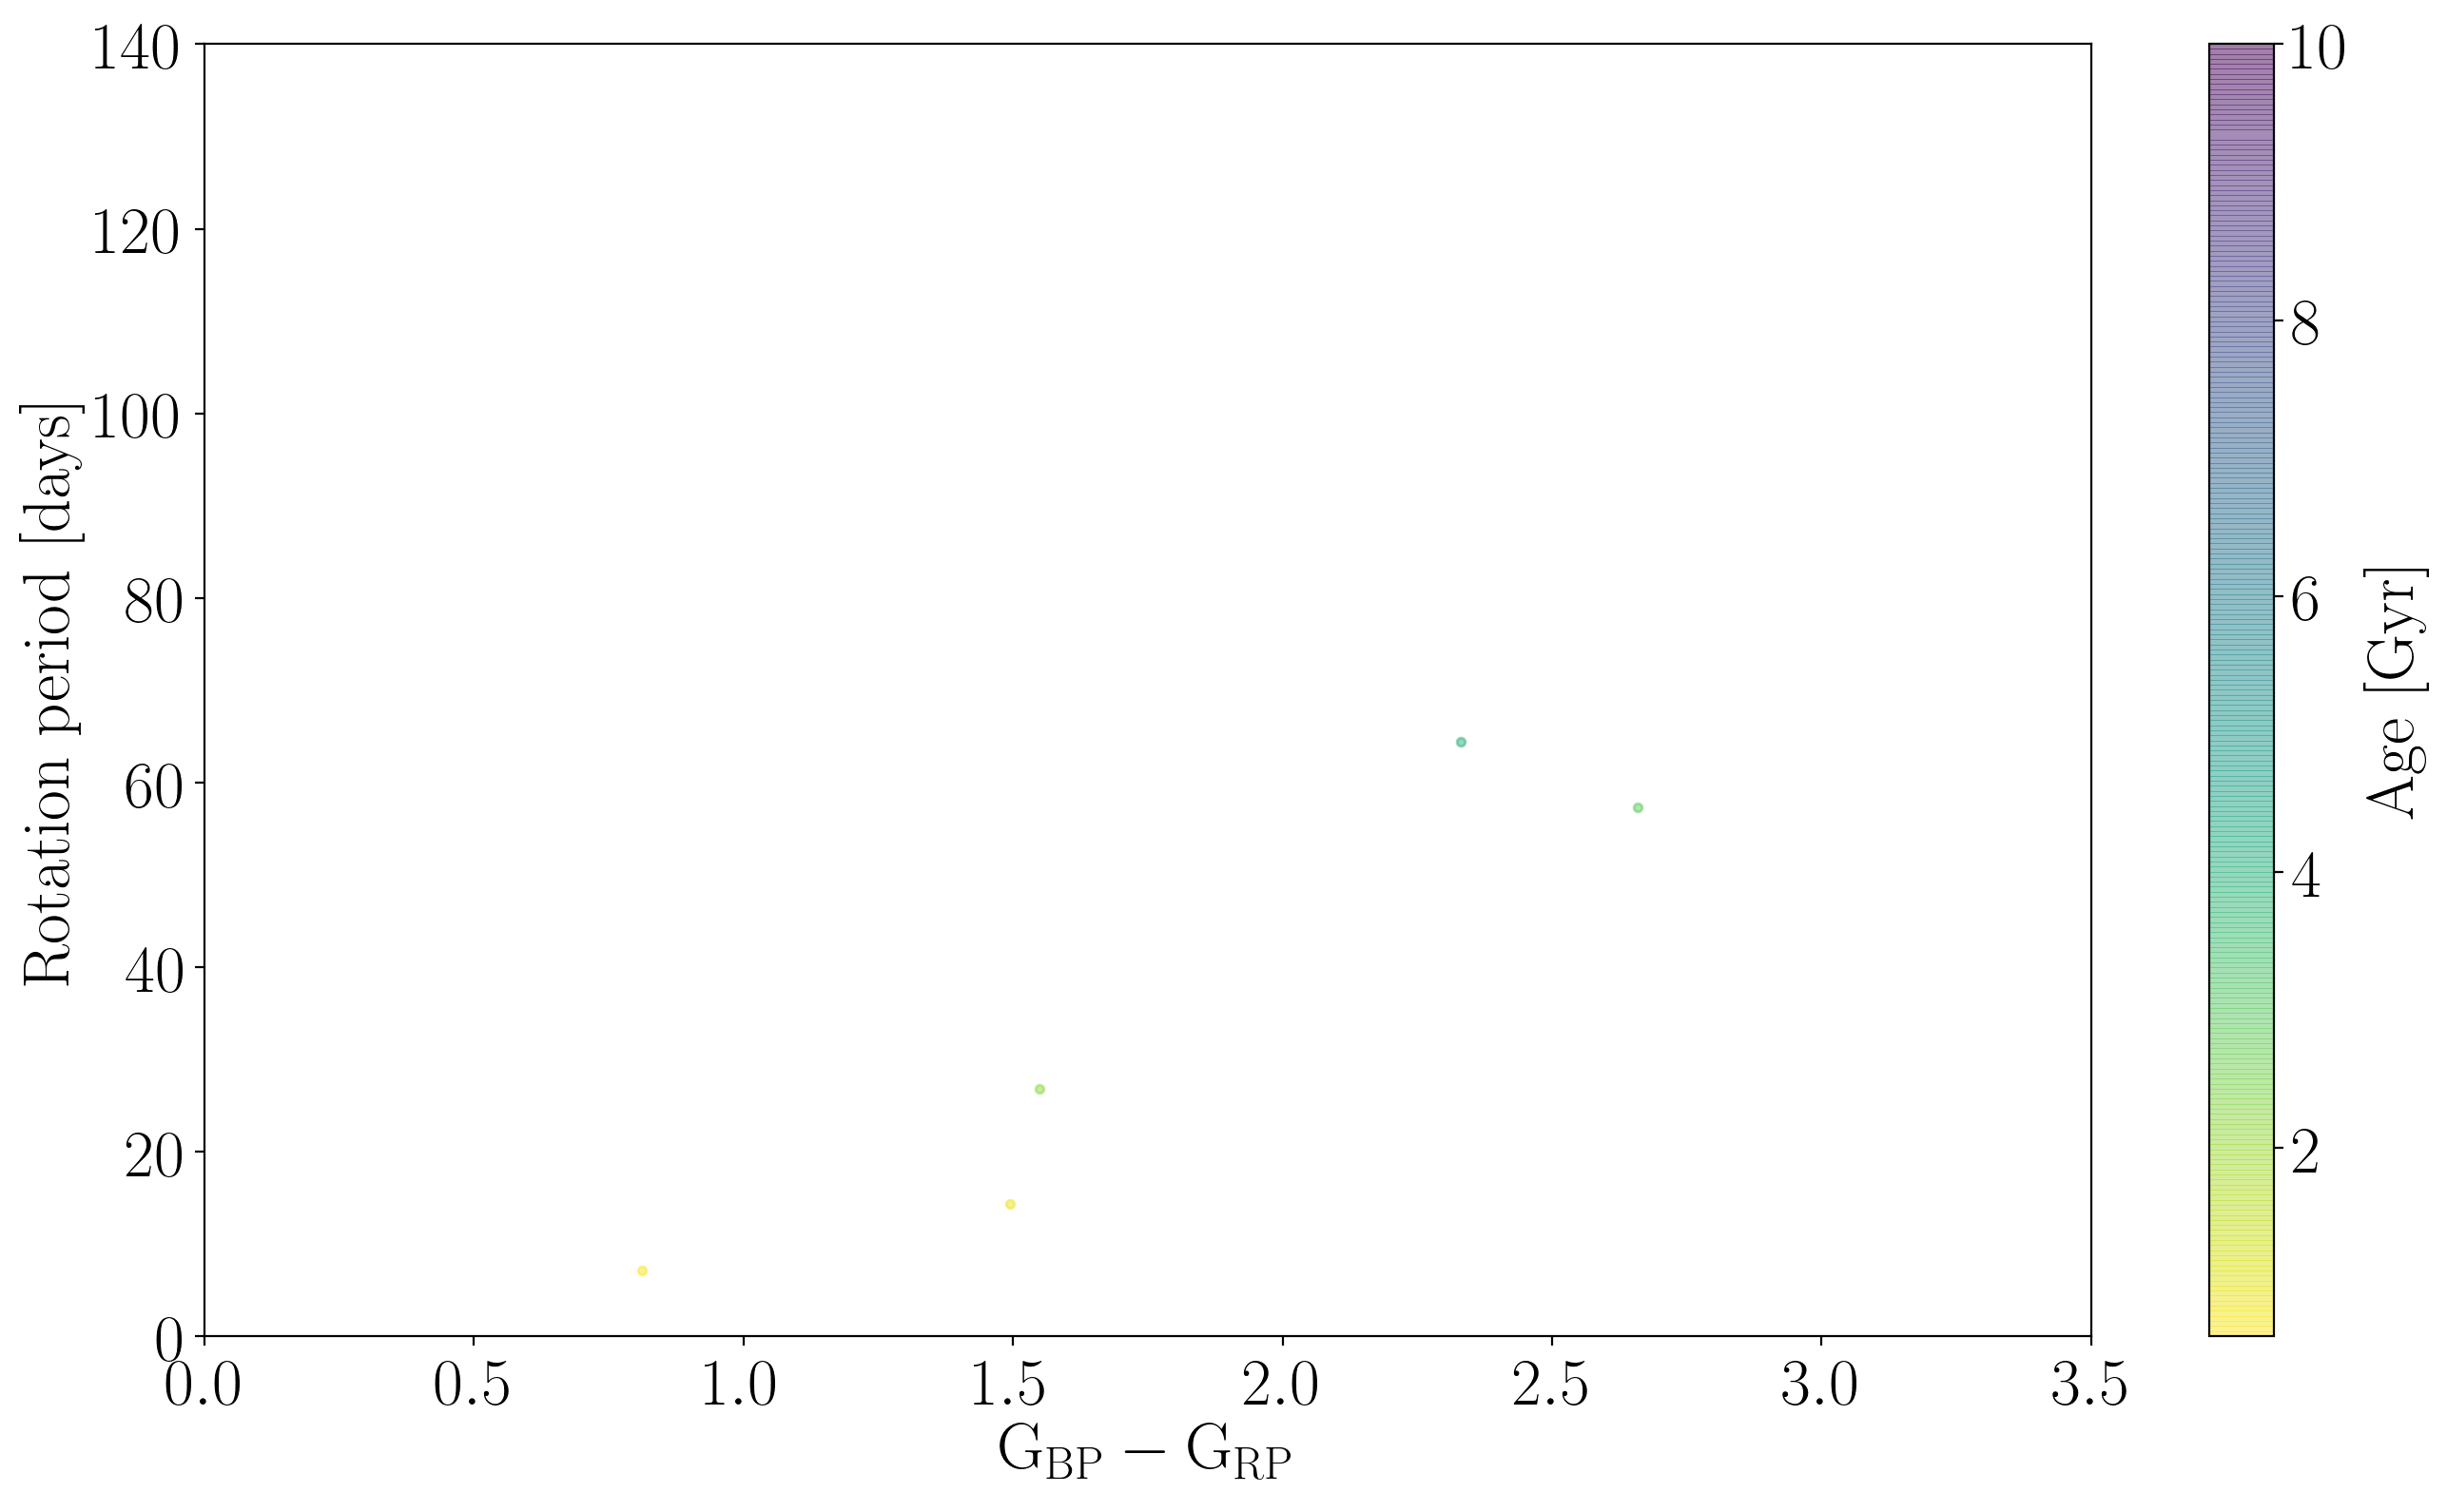

In [6]:
def gyr(log10_age_yrs):
    return (10**log10_age_yrs)*1e-9

plt.figure(figsize=(16, 9), dpi=200)

age_gyr = (10**finite_df.age)*1e-9
for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < age_gyr) * (age_gyr < gyr(i)+.01) * (finite_df.eep < 400)
    plt.scatter(finite_df.bp[m]-finite_df.rp[m], 10**np.log10(finite_df.prot_clean[m]),
                c=age_gyr[m], vmin=gyr(8.8), vmax=10, s=10, alpha=.5, cmap="viridis_r", rasterized=True)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.yscale("log")
plt.ylim(0, 140)
plt.xlim(0, 3.5)

Load the McQuillan catalog and compare

In [7]:
mc = pd.read_csv("data/Table_1_Periodic.txt")
H, xedges, yedges = np.histogram2d(mc.Teff, mc.Prot, bins=40)
X, Y = np.meshgrid(xedges, yedges)
X, Y = X[:-1, :-1], Y[:-1, :-1]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


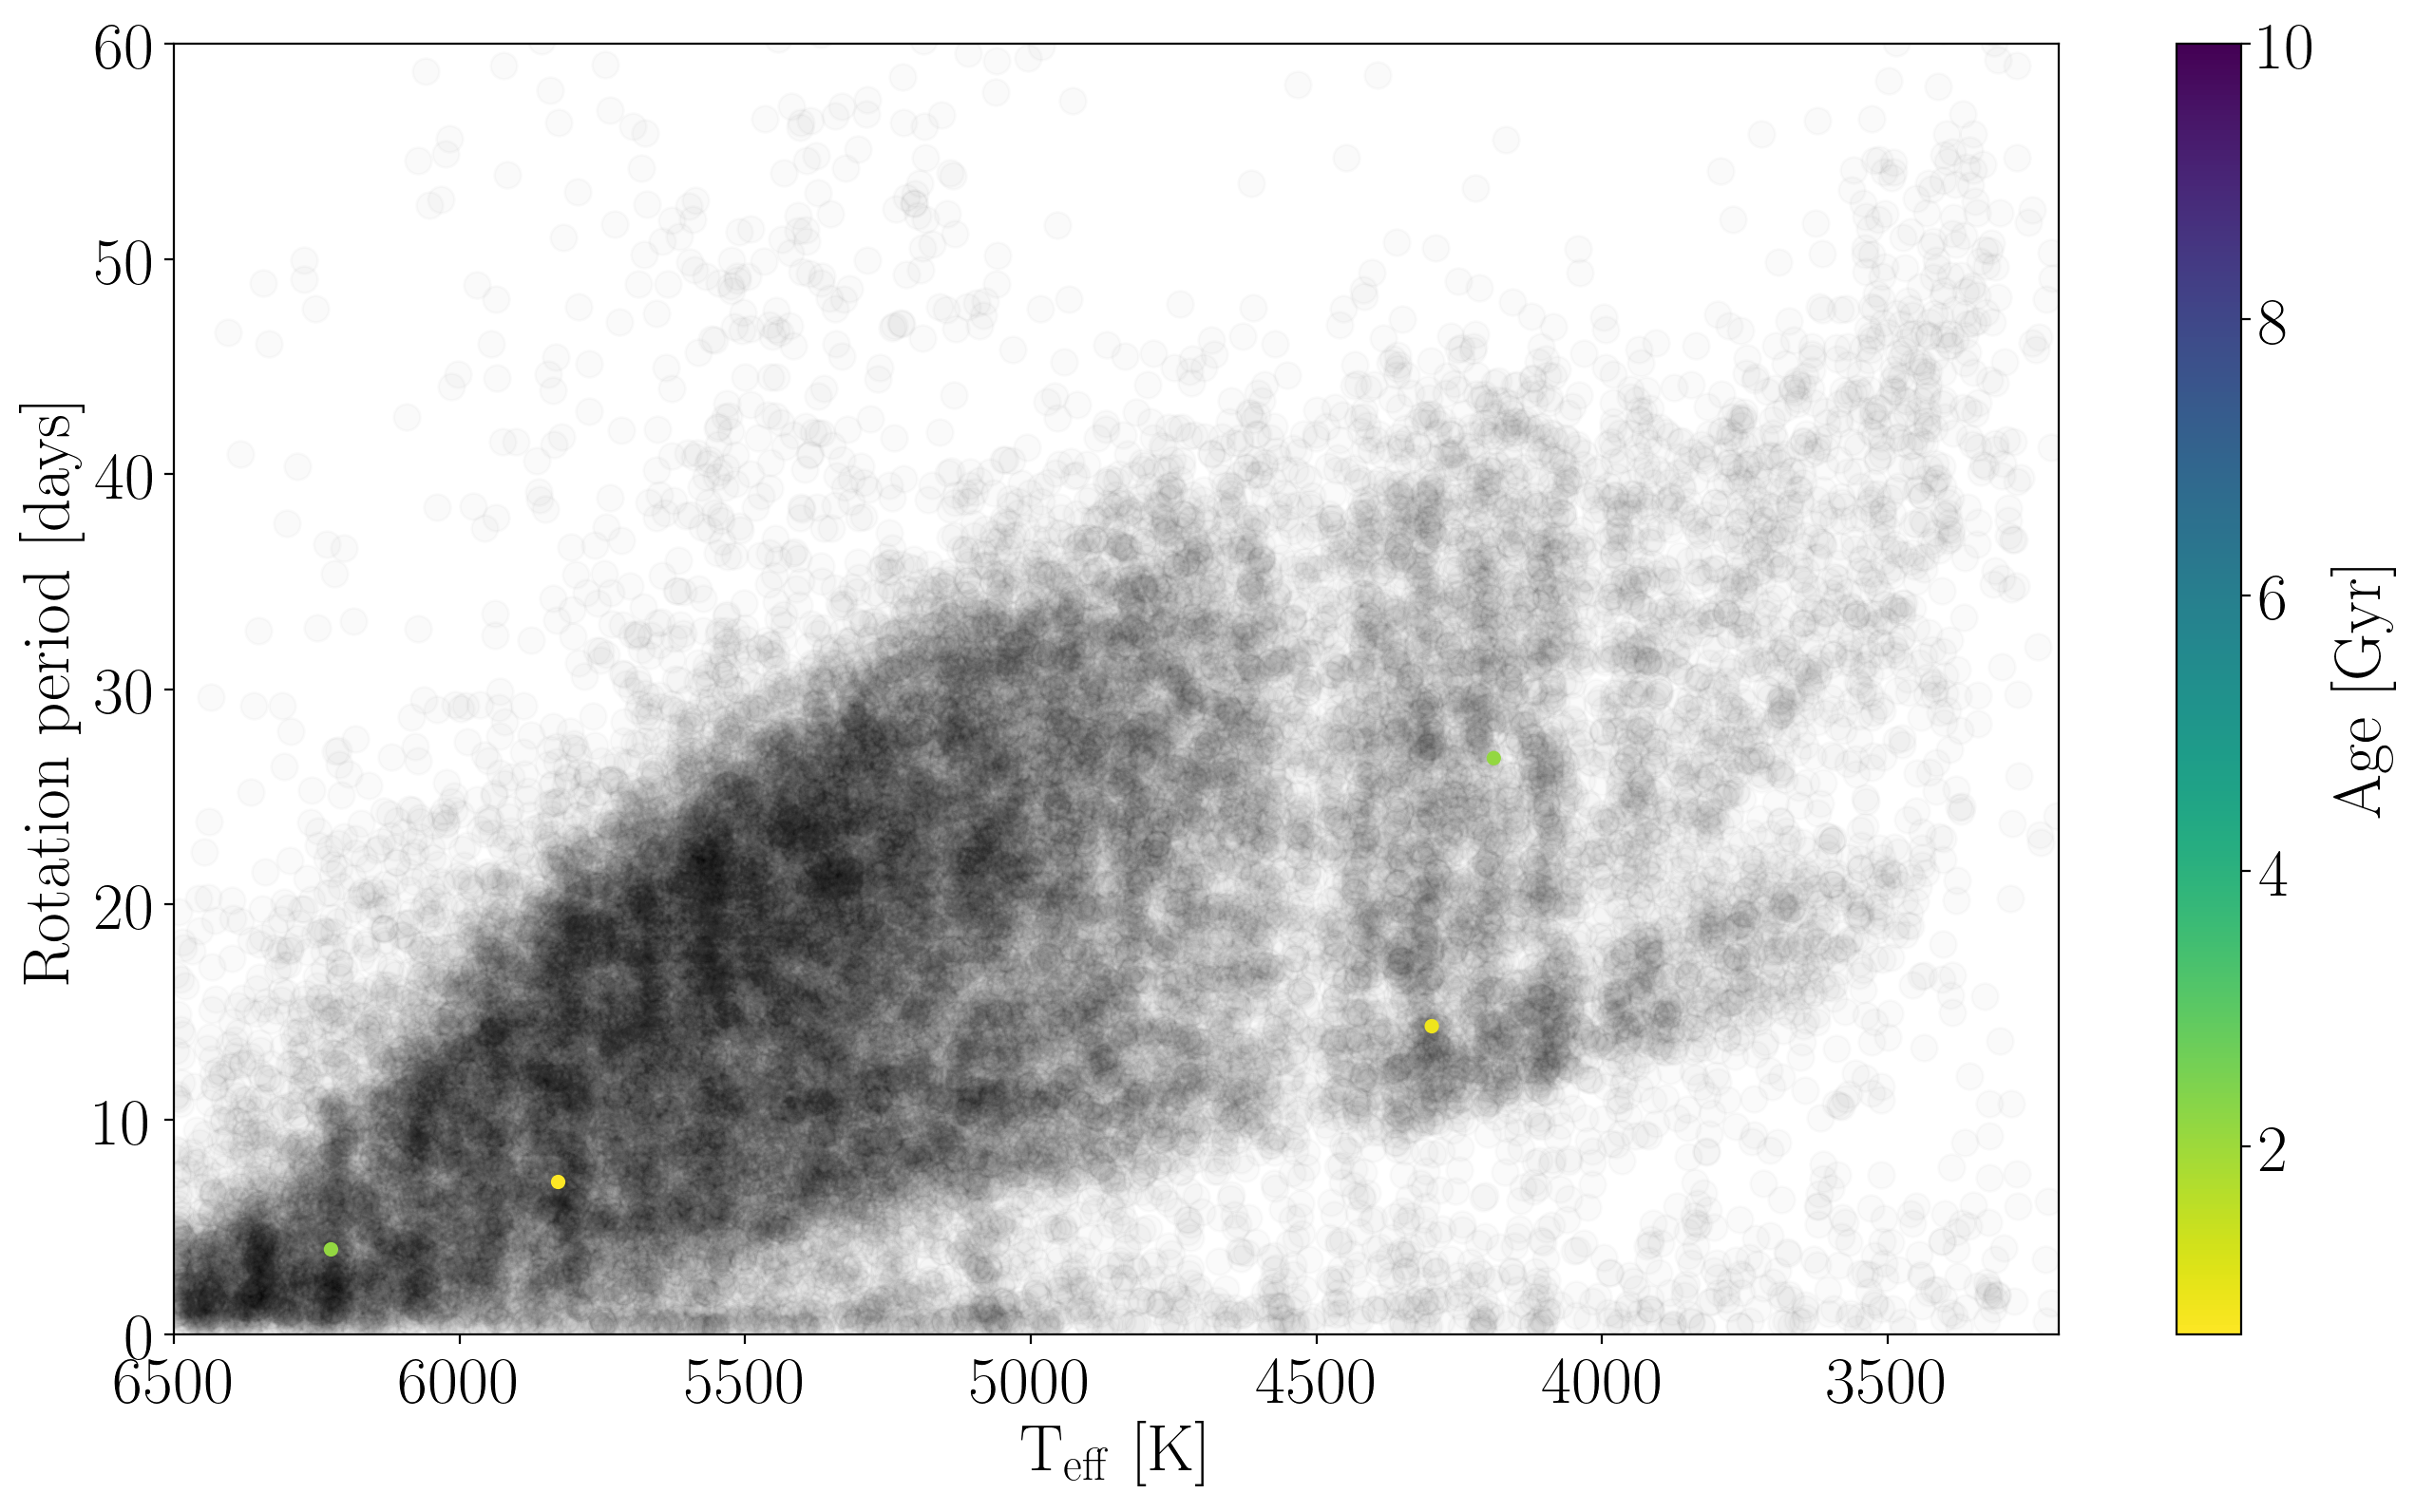

In [8]:
plt.figure(figsize=(16,9), dpi=200)
for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < age_gyr) * (age_gyr < gyr(i)+.01)
    plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot[m]), c=age_gyr[m],
                vmin=gyr(8.8), vmax=10, s=20, alpha=1., cmap="viridis_r", rasterized=True)
plt.plot(mc.Teff, mc.Prot, "k.", alpha=.02, ms=20, zorder=0, rasterized=True)
plt.xlim(6500, 3200)
plt.ylim(0, 60)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.savefig("mcquillan_with_model1.pdf")

/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


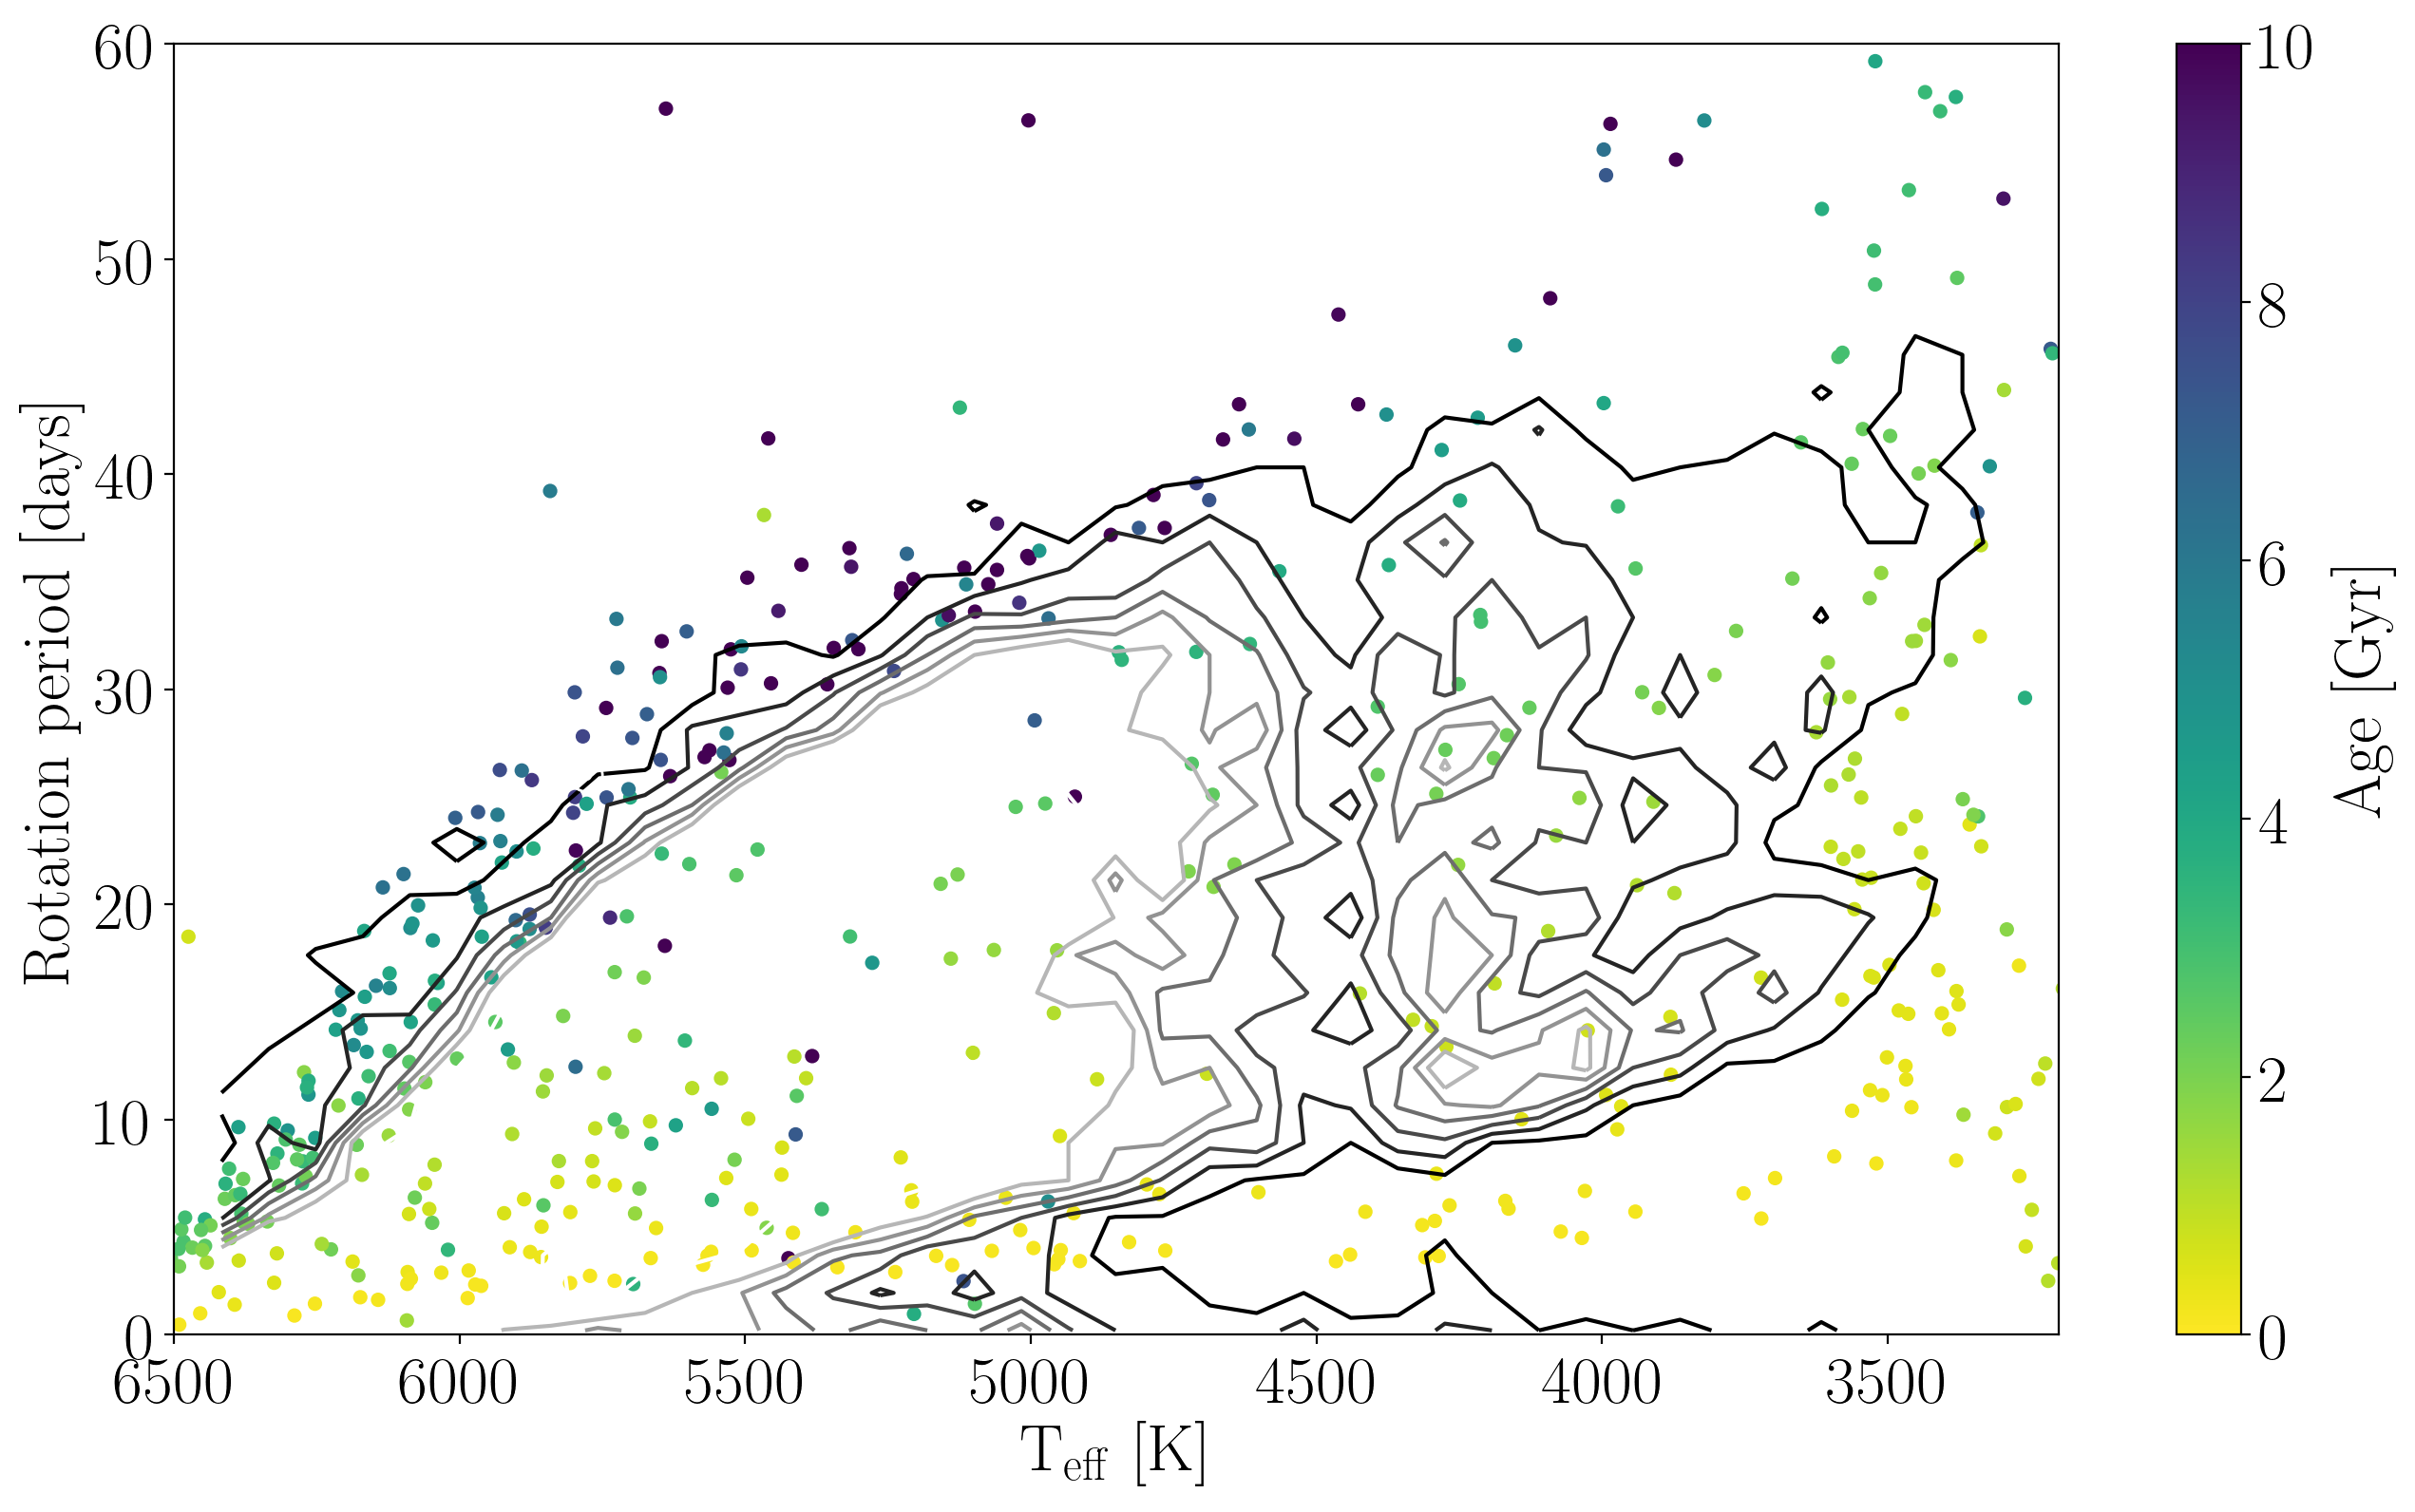

In [9]:
plt.figure(figsize=(16, 9), dpi=200)
plt.contour(X, Y, H.T, levels=[10, 20, 30, 40, 50, 60, 80], cmap="gray",
            zorder=1, rasterized=True)
plt.scatter(finite_df.teff, 10**np.log10(finite_df.prot), c=age_gyr,
            vmin=0, vmax=10, s=20, alpha=1., cmap="viridis_r",
            rasterized=True, zorder=0)

cb = plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
cb.set_alpha(1.)

# Sun
plt.scatter(5778, 26, facecolors='none', edgecolors="w", s=150, zorder=3)
plt.plot(5778, 26, ".w", zorder=3)

plt.xlim(6500, 3200)
plt.ylim(0, 60)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.savefig("mcquillan_with_model2.pdf")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(0, 60)

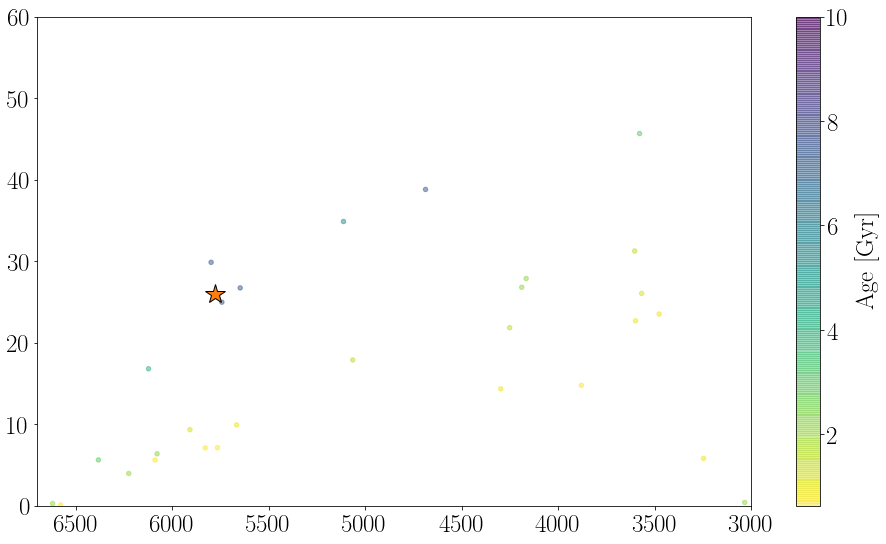

In [10]:
plt.figure(figsize=(16, 9))

for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < age_gyr) * (age_gyr < gyr(i)+.05)
    plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot[m]), c=age_gyr[m],
                vmin=gyr(8.8), vmax=10, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")

# Sun
# plt.scatter(5778, 26, facecolors='none', edgecolors="w", s=150, zorder=3)
# plt.plot(5778, 26, ".w", zorder=3)

plt.plot(5779, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.xlim(6700, 3000)
plt.ylim(0, 60)

Downsample the data for saving.

In [11]:
# small = np.random.randint(0, len(finite_df), 1000)
# df_small = finite_df.iloc[small]
df_small = finite_df

Text(0, 0.5, '$\\log(g)$')

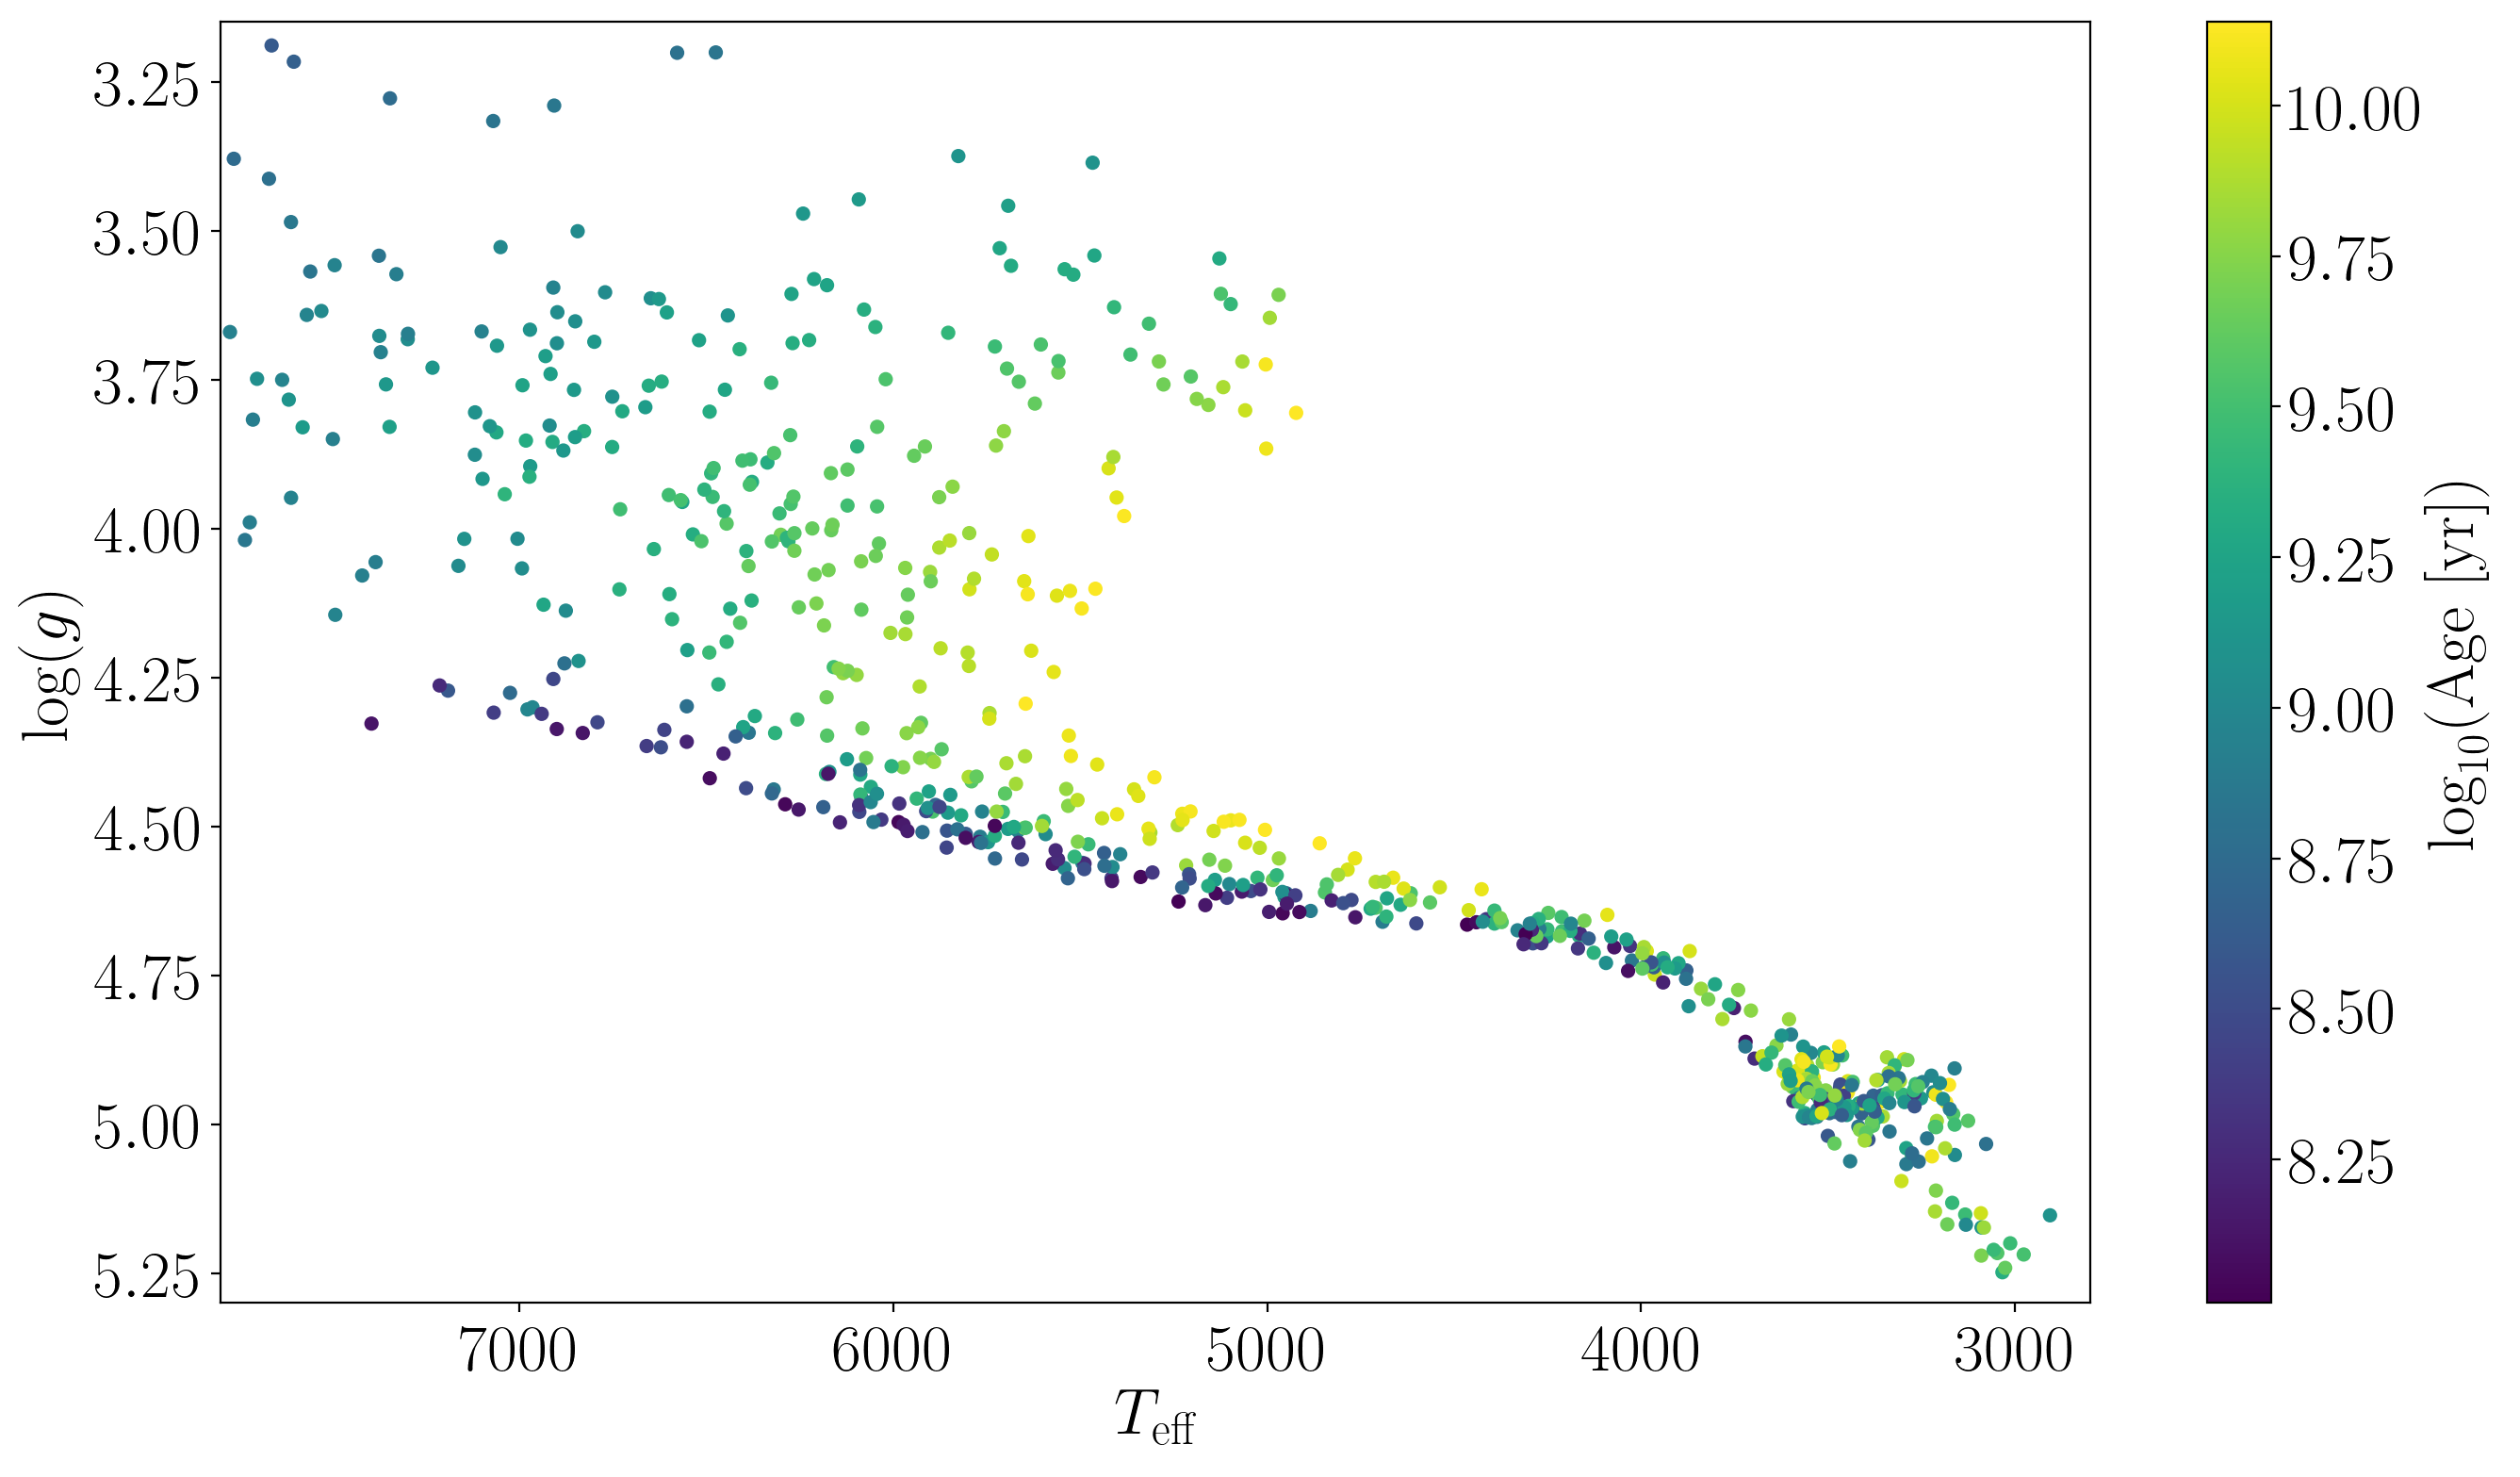

In [12]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df_small.teff, df_small.logg, c=df_small.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

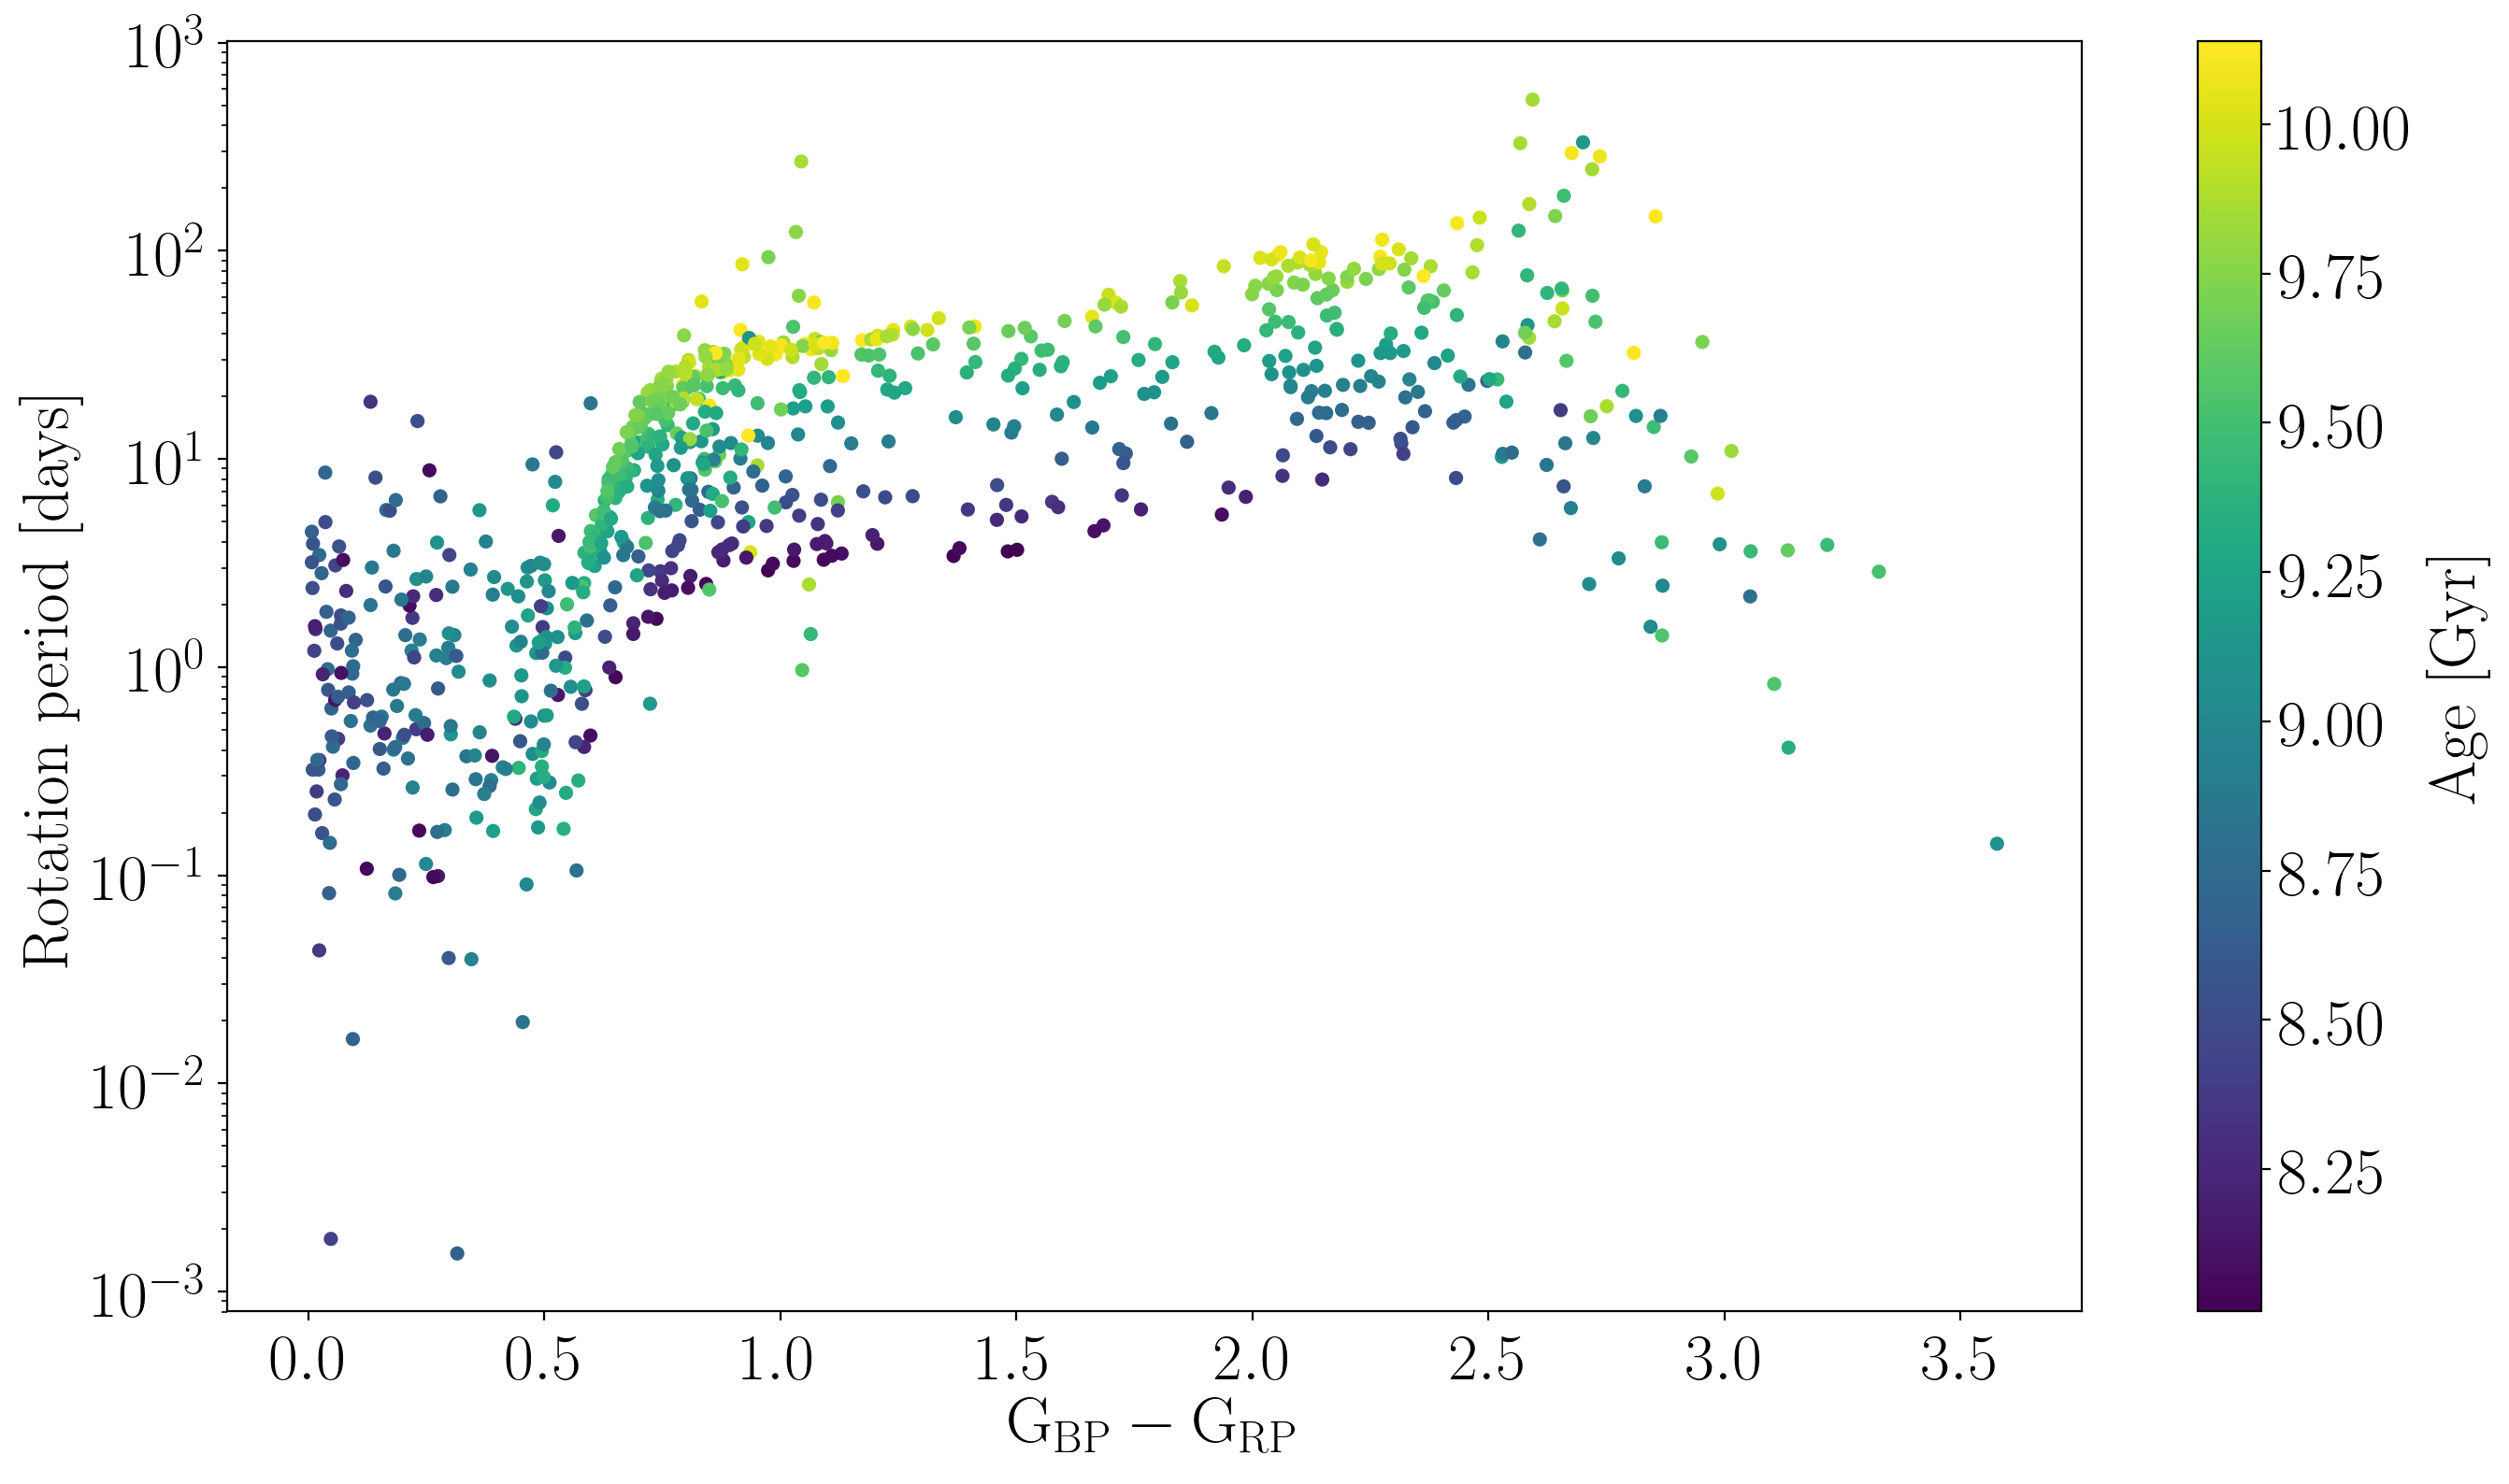

In [13]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(df_small.bp-df_small.rp, df_small.prot, c=df_small.age, s=20, zorder=1)
# plt.yscale("log")
# plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
# plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
# plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.ylim(0, 60)

plt.figure(figsize=(16, 9), dpi=200)
plt.yscale("log")
plt.scatter(df_small.bp-df_small.rp, df_small.prot, c=df_small.age, s=20, zorder=1)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

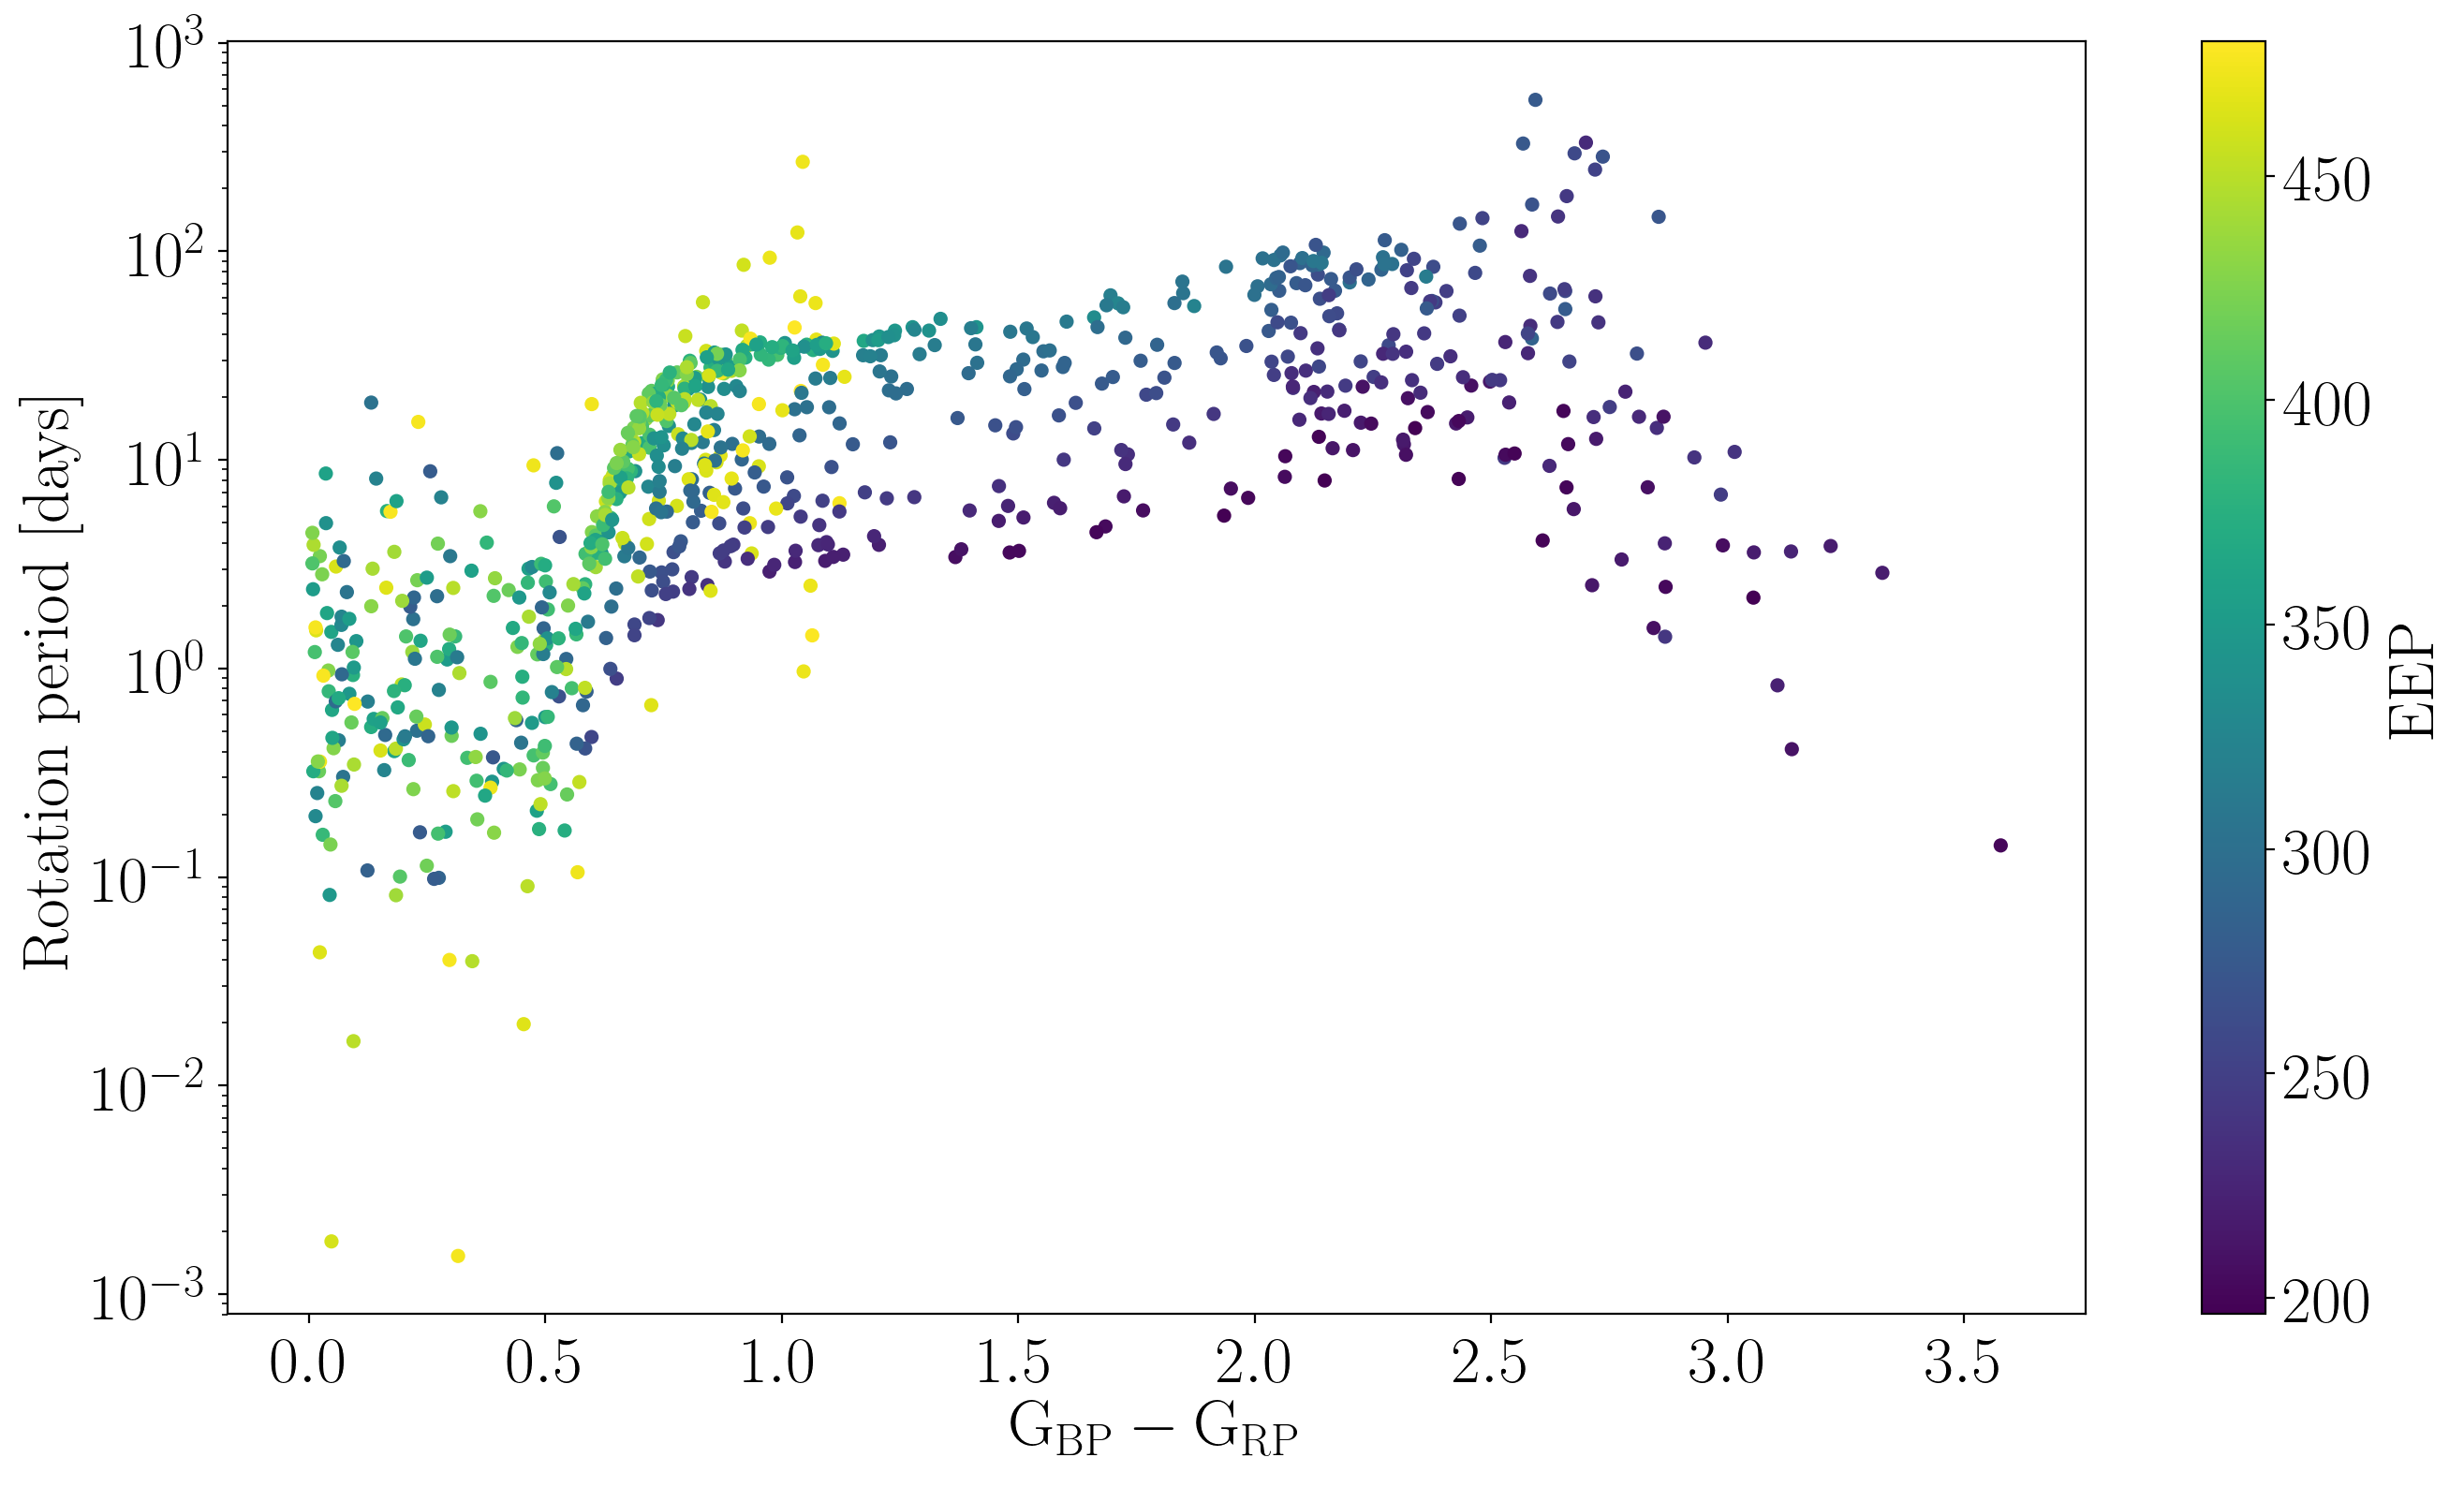

In [14]:
plt.figure(figsize=(16, 9), dpi=200)
plt.yscale("log")
plt.scatter(df_small.bp-df_small.rp, df_small.prot, c=df_small.eep, s=20, zorder=1)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

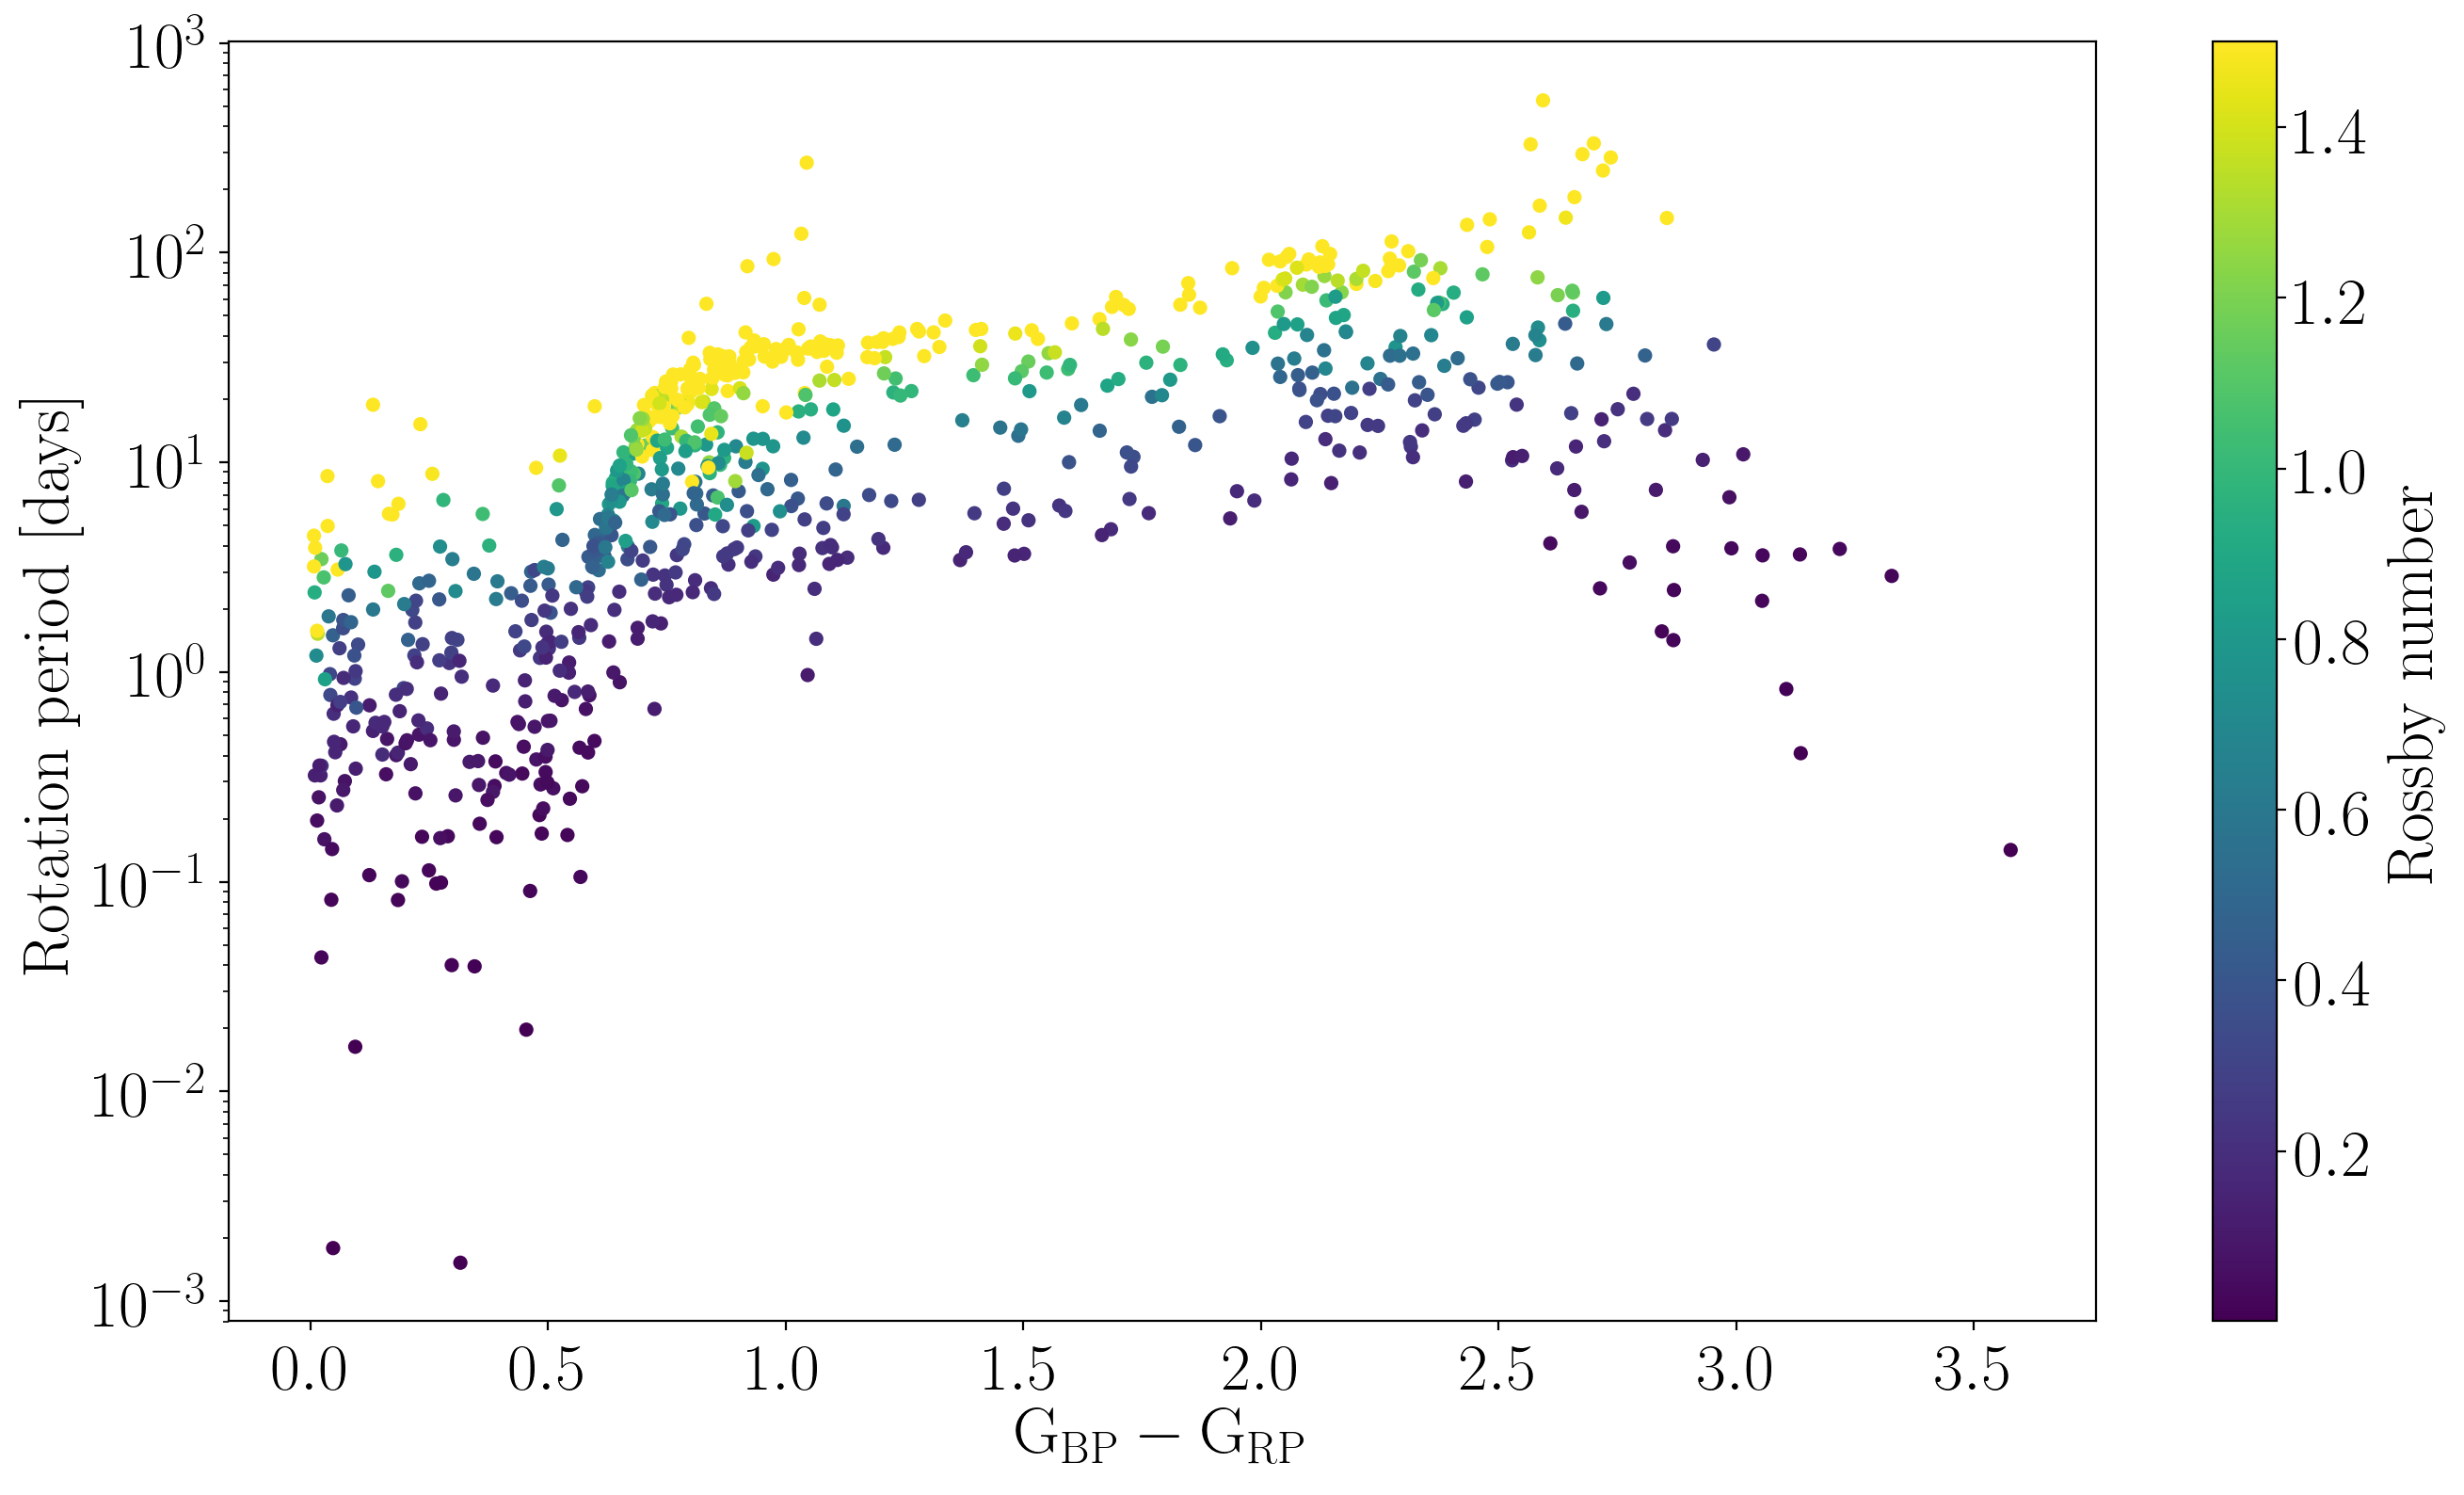

In [15]:
plt.figure(figsize=(16, 9), dpi=200)
plt.yscale("log")
plt.scatter(df_small.bp-df_small.rp, df_small.prot, c=df_small.Ro, s=20, vmax=1.5, zorder=1)
plt.colorbar(label="$\mathrm{Rossby~number}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.ylim(5, 150)
# plt.xlim(.5, 3)

Save the data.

In [16]:
df_small["ID"] = range(len(df_small))
df_small.to_csv("data/simulated_data.csv")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[-0.11560761432904847, 1.0567845843133234, -3.60927954061752, 5.8871481669465044, -5.271183422033972, 3.0529561079631575]


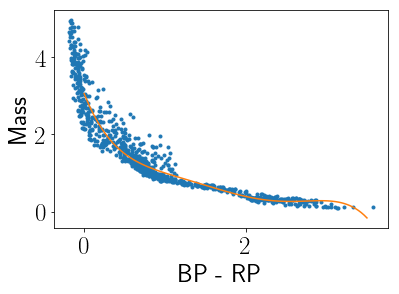

In [17]:
x, y = df.bp - df.rp, df.mass
yerr = np.ones(len(df.mass))*.01
m = np.isfinite(x) * np.isfinite(y)
x, y, yerr = x[m], y[m], yerr[m]

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(model(p, x) - y)**2/yerr**2)

import scipy.optimize as spo
p0 = np.ones(6)
results = spo.minimize(nll, p0, args=(x, y, yerr))

plt.errorbar(x, y, fmt=".", zorder=0)
xs = np.linspace(0, 3.5, 100)
plt.plot(xs, model(results.x, xs), zorder=1)
plt.xlabel("BP - RP")
plt.ylabel("Mass")
print(list(results.x))

def bprp_to_mass(bprp):
    p = [-0.05103786886729474, 0.5403925124845914, 
         -2.215017525879742, 4.493433369049416,
         -4.977087548602282, 3.118005674618441]
    return np.polyval(p, bprp)